In [35]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [90]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Average density

In [4]:
abacus_halos = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800.npy')
abacus_particles_nbar001 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.001.npy')
abacus_particles_nbar003 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003.npy')
abacus_particles_nbar012 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.012.npy')
#abacus_particles_nbar025 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.025.npy')

In [5]:
nbar_halos = abacus_halos.size / boxsize**3
print('halos density:', nbar_halos)
nbar = nbar_halos

halos density: 0.003442710625


In [6]:
abacus_particles_nbar012.size / boxsize**3

0.01238355525

## Bias

[000006.52]  02-05 10:09  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z0.800_2PCF.npy.
[000006.73]  02-05 10:09  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z0.800_downsampled_particles_2PCF.npy.


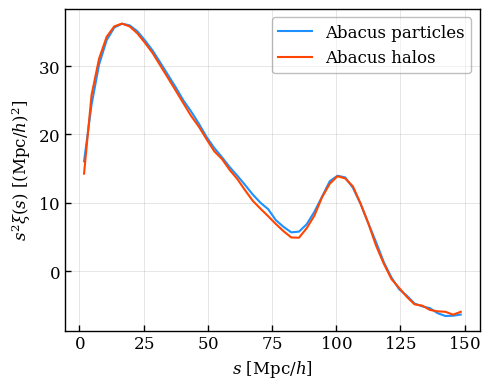

In [7]:
from pycorr import TwoPointCorrelationFunction

ells = [0]

# Abacus 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xi_abacus_halos = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z0.800_2PCF.npy')
xi_abacus_particles = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_2PCF.npy')
sep, xi_ells_abacus_halos = xi_abacus_halos.get_corr(ells=ells, return_sep=True)
sep, xi_ells_abacus_particles = xi_abacus_particles.get_corr(ells=ells, return_sep=True)

bias = 1.5 # adjusted to match xi from particles and halos

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * bias**2 * xi_ells_abacus_particles[ill], label='Abacus particles')
    plt.plot(sep, sep**2 * xi_ells_abacus_halos[ill], label='Abacus halos')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

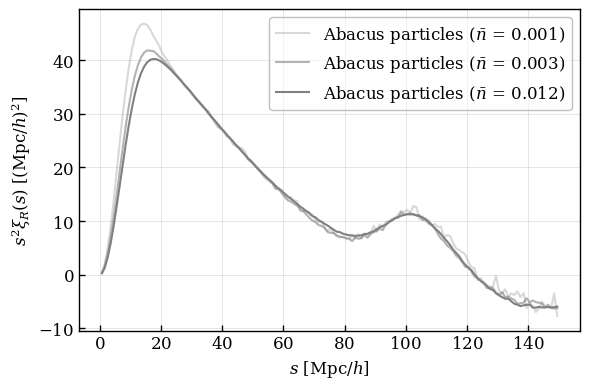

In [397]:
# Abacus smoothed 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xiR_abacus_halos = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
xiR_abacus_particles = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
xiR_abacus_particles_nbar001 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.001_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
xiR_abacus_particles_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
xiR_abacus_particles_nbar012 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
sep, xiR_ells_abacus_halos = xiR_abacus_halos.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_particles_nbar001 = xiR_abacus_particles_nbar001.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_particles_nbar003 = xiR_abacus_particles_nbar003.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_particles_nbar012 = xiR_abacus_particles_nbar012.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_particles = xiR_abacus_particles.item().get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * bias**2 * xiR_ells_abacus_particles_nbar001[ill], label=r'Abacus particles ($\bar{n}$ = 0.001)', color='grey', alpha=0.3)
    plt.plot(sep, sep**2 * bias**2 * xiR_ells_abacus_particles_nbar003[ill], label=r'Abacus particles ($\bar{n}$ = 0.003)', color='grey', alpha=0.6)
    #plt.plot(sep, sep**2 * bias**2 * xiR_ells_abacus_particles[ill], label=r'Abacus particles ($\bar{n}$ = 0.013)', color='grey', alpha=1)
    plt.plot(sep, sep**2 * bias**2 * xiR_ells_abacus_particles_nbar012[ill], label=r'Abacus particles ($\bar{n}$ = 0.012)', color='grey', alpha=1)
    #plt.plot(sep, sep**2 * xiR_ells_abacus_halos[ill], label='Abacus halos', color='dodgerblue')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

## Gaussian model

In [17]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=nbar, damping=False)

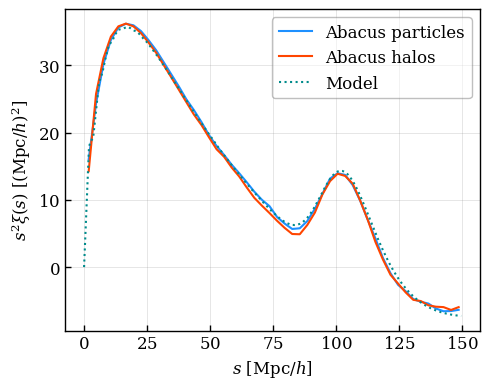

In [18]:
sep, xi_ells_abacus_halos = xi_abacus_halos.get_corr(ells=ells, return_sep=True)
sep, xi_ells_abacus_particles = xi_abacus_particles.get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * bias**2 * xi_ells_abacus_particles[ill], label='Abacus particles')
    plt.plot(sep, sep**2 * xi_ells_abacus_halos[ill], label='Abacus halos')
    plt.plot(model.sep, model.sep**2 * bias**2 * model.xi, label=r'Model', ls=':')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

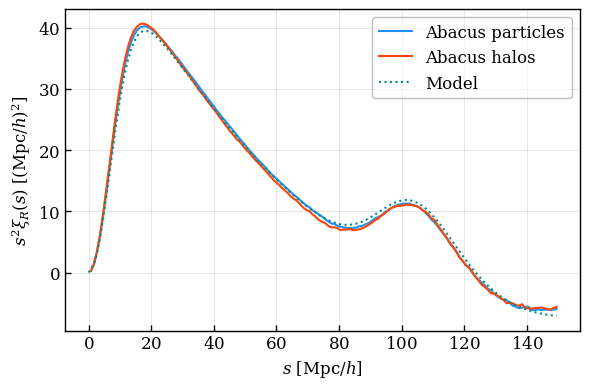

In [270]:
sep, xiR_ells_abacus_halos = xiR_abacus_halos.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_particles  = xiR_abacus_particles.item().get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * bias**2 * xiR_ells_abacus_particles[ill], label='Abacus particles')
    plt.plot(sep, sep**2 * xiR_ells_abacus_halos[ill], label='Abacus halos')
    plt.plot(model.sep, model.sep**2 * bias**2 * model.xi_R, label=r'Model', ls=':')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

## Mock $\delta_R$

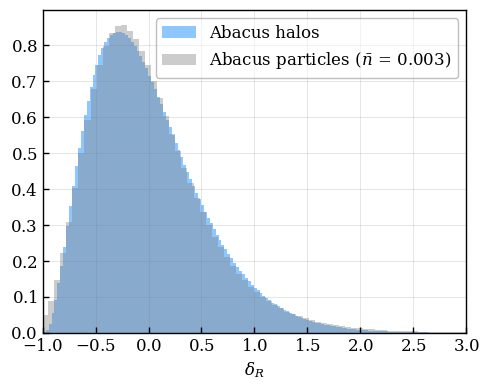

In [20]:
# halos
abacus_halos_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z{:.3f}_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
# particles
abacus_particles_nbar001_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.001_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_nbar003_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_nbar012_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))

plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.5, label='Abacus halos')
#plt.hist(bias*abacus_particles_nbar001_delta_R, bins=200, density=True, alpha=0.6, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.001)')
plt.hist(bias*abacus_particles_nbar003_delta_R, bins=200, density=True, alpha=0.4, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.003)')
#plt.hist(bias*abacus_particles_nbar012_delta_R, bins=200, density=True, alpha=0.2, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.012)')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

In [271]:
print(np.mean(abacus_particles_nbar001_delta_R))
print(np.mean(abacus_particles_nbar003_delta_R))
print(np.mean(abacus_particles_nbar012_delta_R))
print(np.mean(abacus_halos_delta_R))

0.0003253895685985367
-9.332350889368052e-05
9.497475666968173e-06
-4.6031561491820734e-06


In [273]:
print(np.std(abacus_particles_nbar001_delta_R))
print(np.std(abacus_particles_nbar003_delta_R))
print(np.std(abacus_particles_nbar012_delta_R))
print(np.std(abacus_halos_delta_R)/bias)

0.4071181372043062
0.36788276451965546
0.3467947414181791
0.35188168437924405


In [287]:
th_moments = model.smoothed_density_moments()

In [290]:
model.sigma_RR

array([0.33810308])

In [302]:
np.sqrt(th_moments[1] - 1)

array([0.55754086])

In [293]:
def compute_delta0_sigma(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = moment(delta_R, 2)
    if m3 is None:
        m3 = moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 + 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0_particles_nbar012, sigma_particles_nbar012 = compute_delta0_sigma(abacus_particles_nbar012_delta_R)
print(delta0_particles_nbar012)
print(sigma_particles_nbar012)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.3583882284932933e-09
        x: [ 7.711e-01]
      nit: 3
      jac: [-5.655e-06]
 hess_inv: [[ 2.318e+02]]
     nfev: 14
     njev: 7
0.7710584588548476
0.4292161628201828


## Model for $\delta_R$

In [86]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

def shot_noise_model(N, Nbar, delta0, sigma):
    delta = np.linspace(-1, 11, 100)
    pdf_deltag = friedrich_lognormal_model(delta, sigma, delta0)
    shotnoise = np.exp(N * np.log((Nbar * (1 + delta)))) / scipy.special.gamma(N+1) * np.exp(-Nbar * (1 + delta))
    pdf_N = np.trapz(pdf_deltag * shotnoise, delta)
    return pdf_N

delta = np.linspace(-1, 3, 200)

### Ideal case (no bias, small shot noise)

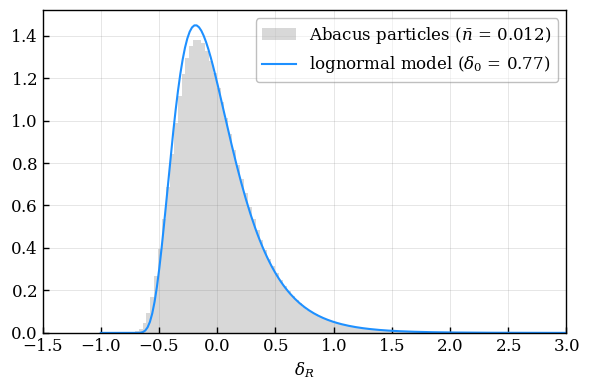

In [92]:
plt.rcParams["figure.figsize"] = (6, 4)

pdf_particles_nbar012 = plt.hist(abacus_particles_nbar012_delta_R, bins=200, density=True, alpha=0.3, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.012)')
plt.plot(delta, friedrich_lognormal_model(delta, np.sqrt(np.log(1 + model.sigma_RR**2)), delta0_particles_nbar012), color='C0', label=r'lognormal model ($\delta_0$ = {:.2f})'.format(delta0_particles_nbar012))
plt.xlabel(r'$\delta_R$')
plt.xlim((-1.5, 3))
plt.legend()
plt.show()

In [297]:
delta0_particles_nbar001, sigma_particles_nbar001 = compute_delta0_sigma(abacus_particles_nbar001_delta_R)
delta0_particles_nbar003, sigma_particles_nbar003 = compute_delta0_sigma(abacus_particles_nbar003_delta_R, m2=(th_moments[1] - 1))
delta0_particles_nbar012, sigma_particles_nbar012 = compute_delta0_sigma(abacus_particles_nbar012_delta_R)
delta0_halos, sigma_halos = compute_delta0_sigma(abacus_halos_delta_R, m2=(th_moments[1] - 1))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.196690941750322e-10
        x: [ 1.024e+00]
      nit: 3
      jac: [-3.550e-06]
 hess_inv: [[ 1.069e+02]]
     nfev: 12
     njev: 6
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.1159045773773336e-07
        x: [ 4.837e+00]
      nit: 12
      jac: [-8.168e-06]
 hess_inv: [[ 2.505e+03]]
     nfev: 26
     njev: 13
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.3583882284932933e-09
        x: [ 7.711e-01]
      nit: 3
      jac: [-5.655e-06]
 hess_inv: [[ 2.318e+02]]
     nfev: 14
     njev: 7
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.646358407328108e-11
        x: [ 2.020e+00]
      nit: 9
      jac: [-1.070e-06]
 hess_inv: [[ 1.113e+02]]
     nfev: 20
     njev: 10


In [298]:
print(sigma_particles_nbar001)
print(sigma_particles_nbar003)
print(sigma_particles_nbar012)
print(sigma_halos)

0.3830434263557161
[0.11488505]
0.4292161628201828
[0.27101717]


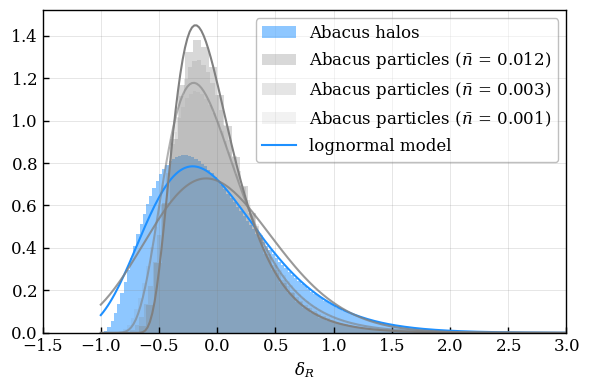

In [299]:
plt.rcParams["figure.figsize"] = (6, 4)

pdf_halos = plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.5, label='Abacus halos')
pdf_particles_nbar012 = plt.hist(abacus_particles_nbar012_delta_R, bins=100, density=True, alpha=0.3, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.012)')
pdf_particles_nbar003 = plt.hist(abacus_particles_nbar003_delta_R, bins=200, density=True, alpha=0.2, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.003)')
pdf_particles_nbar001 = plt.hist(abacus_particles_nbar001_delta_R, bins=200, density=True, alpha=0.1, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.001)')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_halos, delta0_halos), color='C0', label=r'lognormal model')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_particles_nbar012, delta0_particles_nbar012), color='grey', alpha=1)
plt.plot(delta, friedrich_lognormal_model(delta, sigma_particles_nbar003, delta0_particles_nbar003), color='grey', alpha=0.8)
plt.plot(delta, friedrich_lognormal_model(delta, sigma_particles_nbar001, delta0_particles_nbar001), color='grey', alpha=0.6)
plt.xlabel(r'$\delta_R$')
plt.xlim((-1.5, 3))
plt.legend()
plt.show()

In [121]:
def to_minimize(delta0, *args):
    pdf = args
    sigma = model.sigma_RR
    x = pdf[0]
    y = friedrich_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

In [122]:
min_halos = minimize(to_minimize, x0=1., args=pdf_halos)
print(min_halos)

min_particles_nbar001 = minimize(to_minimize, x0=1., args=pdf_particles_nbar001)
print(min_particles_nbar001)

min_particles_nbar003 = minimize(to_minimize, x0=1., args=pdf_particles_nbar003)
print(min_particles_nbar003)

min_particles_nbar012 = minimize(to_minimize, x0=1., args=pdf_particles_nbar012)
print(min_particles_nbar012)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.04119742466393163
        x: [ 1.574e+00]
      nit: 7
      jac: [-4.424e-06]
 hess_inv: [[ 5.246e-02]]
     nfev: 16
     njev: 8
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0004808264788937597
        x: [ 1.162e+00]
      nit: 5
      jac: [ 3.613e-06]
 hess_inv: [[ 2.764e-02]]
     nfev: 14
     njev: 7
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0029616836720539183
        x: [ 1.040e+00]
      nit: 5
      jac: [ 3.871e-09]
 hess_inv: [[ 2.241e-02]]
     nfev: 14
     njev: 7
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.007579091363127891
        x: [ 9.731e-01]
      nit: 4
      jac: [ 1.740e-08]
 hess_inv: [[ 3.166e-02]]
     nfev: 14
     njev: 7


In [124]:
model.sigma_RR

array([0.33810308])

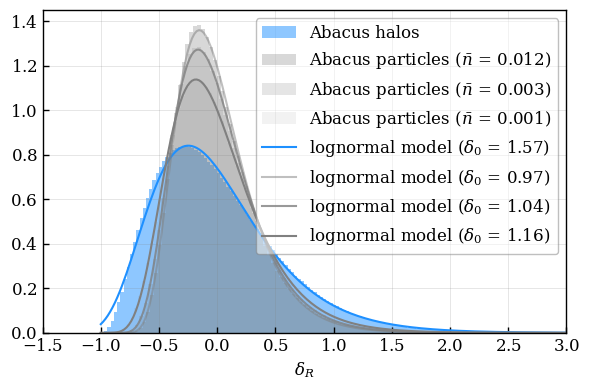

In [303]:
plt.rcParams["figure.figsize"] = (6, 4)

pdf_halos = plt.hist(abacus_halos_delta_R, bins=200, density=True, alpha=0.5, label='Abacus halos')
pdf_particles_nbar012 = plt.hist(abacus_particles_nbar012_delta_R, bins=200, density=True, alpha=0.3, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.012)')
pdf_particles_nbar003 = plt.hist(abacus_particles_nbar003_delta_R, bins=200, density=True, alpha=0.2, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.003)')
pdf_particles_nbar001 = plt.hist(abacus_particles_nbar001_delta_R, bins=200, density=True, alpha=0.1, color='grey', label=r'Abacus particles ($\bar{n}$ = 0.001)')
plt.plot(delta, friedrich_lognormal_model(delta, model.sigma_RR, min_halos.x[0]), color='C0', label=r'lognormal model ($\delta_0$ = {:.2f})'.format(min_halos.x[0]))
plt.plot(delta, friedrich_lognormal_model(delta, model.sigma_RR, min_particles_nbar012.x[0]), color='grey', alpha=0.5, label=r'lognormal model ($\delta_0$ = {:.2f})'.format(min_particles_nbar012.x[0]))
plt.plot(delta, friedrich_lognormal_model(delta, model.sigma_RR, min_particles_nbar003.x[0]), color='grey', alpha=0.8, label=r'lognormal model ($\delta_0$ = {:.2f})'.format(min_particles_nbar003.x[0]))
plt.plot(delta, friedrich_lognormal_model(delta, model.sigma_RR, min_particles_nbar001.x[0]), color='grey', alpha=1, label=r'lognormal model ($\delta_0$ = {:.2f})'.format(min_particles_nbar001.x[0]))
plt.xlabel(r'$\delta_R$')
plt.xlim((-1.5, 3))
plt.legend()
plt.show()

## Lognormal model for density splits

In [125]:
nsplits = 3
th_bins = np.array([-1., -0.18346272,  0.09637895, np.inf])

In [259]:
def compute_main_term(delta, sigma, delta0=1., delta0_R=1., bias=1., xi_R=None):
    if xi_R is None:
        xi_R = model.xi_R * bias**2
    if math.isfinite(delta):
        a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
        b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
    else:
        if delta > 0:
            a = np.full_like(model.xi_R, 1)
            b = np.full_like(model.xi_R, 1)
        if delta < 0:
            a = np.full_like(model.xi_R, -1)
            b = np.full_like(model.xi_R, -1)
    return a, b

def compute_dsplits(sigma, delta0=1., delta0_R=1., th_bins=th_bins, bias=1., xi_R=None):
    dsplits = list()

    for i in range(len(th_bins)-1):
        d1 = max(th_bins[i], -delta0_R)
        d2 = th_bins[i+1]
        a1, b1 = compute_main_term(d1, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R)
        a2, b2 = compute_main_term(d2, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R)
        main_term = (a2 - a1) / (b2 - b1)
        dsplits.append(delta0*(main_term - 1))

    return dsplits

In [260]:
colors = ['firebrick', 'violet', 'olivedrab']

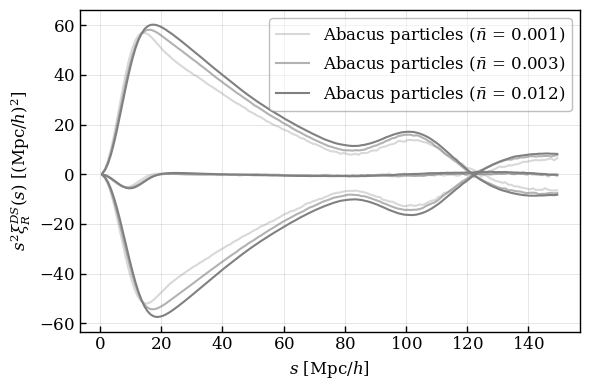

In [261]:
# Abacus density splits
split_xi_abacus_halos = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_halos = split_xi_abacus_halos.item()['rh']
split_xi_ells_abacus_halos = [split_xi_abacus_halos[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_halos[0].get_corr(ells=ells, return_sep=True)

# particles
split_xi_abacus_particles_nbar001 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.001_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_particles_nbar001 = split_xi_abacus_particles_nbar001.item()['rh']
split_xi_ells_abacus_particles_nbar001 = [split_xi_abacus_particles_nbar001[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_particles_nbar001[0].get_corr(ells=ells, return_sep=True)

split_xi_abacus_particles_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_particles_nbar003 = split_xi_abacus_particles_nbar003.item()['rh']
split_xi_ells_abacus_particles_nbar003 = [split_xi_abacus_particles_nbar003[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_particles_nbar003[0].get_corr(ells=ells, return_sep=True)

split_xi_abacus_particles_nbar012 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_particles_nbar012 = split_xi_abacus_particles_nbar012.item()['rh']
split_xi_ells_abacus_particles_nbar012 = [split_xi_abacus_particles_nbar012[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_particles_nbar012[0].get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        #plt.plot(sep, sep**2 * split_xi_ells_abacus_halos[ds][0], label=r'DS{}'.format(ds+1), ls='-', color='C0')
        plt.plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar001[ds][0], label=r'DS{}'.format(ds+1), ls='-', color='grey', alpha=0.3)
        plt.plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar003[ds][0], label=r'DS{}'.format(ds+1), ls='-', color='grey', alpha=0.6)
        plt.plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar012[ds][0], label=r'DS{}'.format(ds+1), ls='-', color='grey', alpha=1)
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
#for ds in range(nsplits):
#    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
#    lines.append(line)
#line2, = plt.plot([], [], ls='-', color='black', label='Lognormal mocks')
#line1, = plt.plot([], [], ls='-', color='dodgerblue', label='Abacus halos')
line2, = plt.plot([], [], label=r'Abacus particles ($\bar{n}$ = 0.001)', ls='-', color='grey', alpha=0.3)
line3, = plt.plot([], [], label=r'Abacus particles ($\bar{n}$ = 0.003)', ls='-', color='grey', alpha=0.6)
line4, = plt.plot([], [], label=r'Abacus particles ($\bar{n}$ = 0.012)', ls='-', color='grey', alpha=1)

first_legend = plt.legend(handles=lines, loc='lower right')
#ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3, line4], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

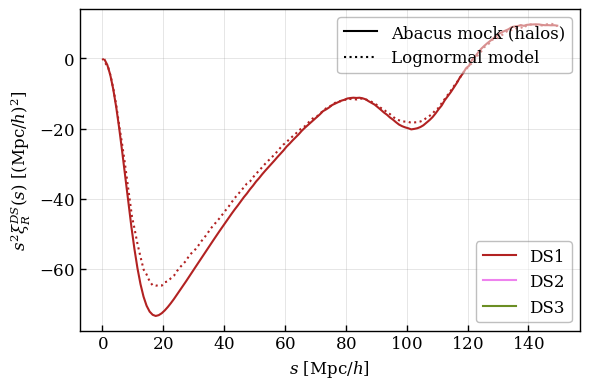

In [316]:
dsplits = compute_dsplits(sigma=sigma_halos, delta0=bias, delta0_R=delta0_halos, bias=bias, xi_R=xiR_ells_abacus_halos[0][:, None])
    
# Abacus density splits
split_xi_abacus_halos = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_halos = split_xi_abacus_halos.item()['rh']
split_xi_ells_abacus_halos = [split_xi_abacus_halos[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_halos[0].get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        plt.plot(sep, sep**2 * split_xi_ells_abacus_halos[ds][0], label=r'DS{}'.format(ds+1), ls='-', color=colors[ds])
        plt.plot(model.sep, model.sep**2 * dsplits[ds], label=r'DS{}'.format(ds+1), ls=':', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
#line2, = plt.plot([], [], ls='-', color='black', label='Lognormal mocks')
line2, = plt.plot([], [], ls='-', color='black', label='Abacus mock (halos)')
line3, = plt.plot([], [], ls=':', color='black', label='Lognormal model')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

/tmp/ipykernel_4052909/3062112955.py:5: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_4052909/3062112955.py:6: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


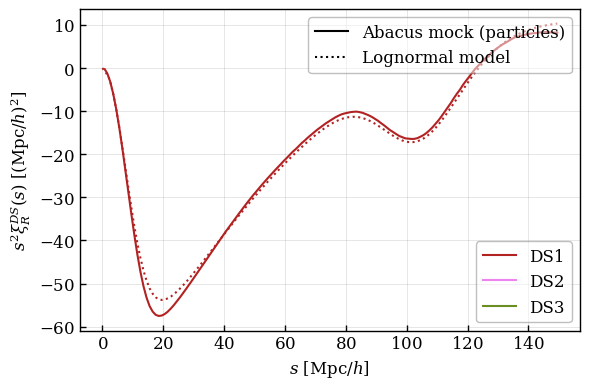

In [317]:
dsplits =  compute_dsplits(sigma=sigma_particles_nbar012, delta0=1., delta0_R=delta0_particles_nbar012, xi_R=None)
    
# Abacus density splits
split_xi_abacus_halos = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_halos = split_xi_abacus_halos.item()['rh']
split_xi_ells_abacus_halos = [split_xi_abacus_halos[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_halos[0].get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        if ds==0:
            plt.plot(sep, sep**2 * split_xi_ells_abacus_halos[ds][0], label=r'DS{}'.format(ds+1), ls='-', color=colors[ds])
            plt.plot(model.sep, model.sep**2 * dsplits[ds], label=r'DS{}'.format(ds+1), ls=':', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
#line2, = plt.plot([], [], ls='-', color='black', label='Lognormal mocks')
line2, = plt.plot([], [], ls='-', color='black', label='Abacus mock (particles)')
line3, = plt.plot([], [], ls=':', color='black', label='Lognormal model')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

In [392]:
## Fit delta0 directly with xi_R_DS
def to_minimize_ccf(params, *args):
    dsplits_ccf = args
    x = np.array(dsplits_ccf).flatten()
    y = np.array(compute_dsplits(sigma=params[2], delta0=params[0], delta0_R=params[1], bias=1., xi_R=xiR_ells_abacus_halos[0][:, None])).flatten()
    return np.sum((x-y)**2)

min_halos_ccf = minimize(to_minimize_ccf, x0=[1., 1.5, 0.3], args=split_xi_ells_abacus_halos)
print(min_halos_ccf)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.02078067251504282
        x: [ 1.351e+00  1.455e+00  3.437e-01]
      nit: 12
      jac: [-2.421e-08  6.545e-07  2.328e-06]
 hess_inv: [[ 2.033e+00  1.329e+00 -2.671e-01]
            [ 1.329e+00  4.039e+00 -8.915e-01]
            [-2.671e-01 -8.915e-01  2.001e-01]]
     nfev: 60
     njev: 15


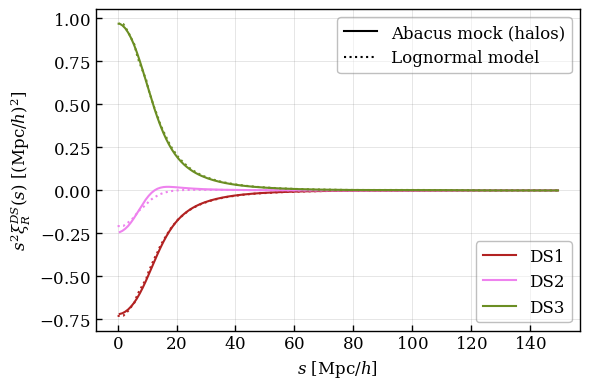

In [394]:
dsplits = compute_dsplits(sigma=min_halos_ccf.x[2], delta0=min_halos_ccf.x[0], delta0_R=min_halos_ccf.x[1], bias=bias, xi_R=xiR_ells_abacus_halos[0][:, None])
    
for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        plt.plot(sep, split_xi_ells_abacus_halos[ds][0], label=r'DS{}'.format(ds+1), ls='-', color=colors[ds])
        plt.plot(model.sep, dsplits[ds], label=r'DS{}'.format(ds+1), ls=':', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
#line2, = plt.plot([], [], ls='-', color='black', label='Lognormal mocks')
line2, = plt.plot([], [], ls='-', color='black', label='Abacus mock (halos)')
line3, = plt.plot([], [], ls=':', color='black', label='Lognormal model')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

In [395]:
sep

array([  0.75007295,   1.60840907,   2.56848329,   3.55119708,
         4.54192649,   5.53577432,   6.53178425,   7.52865698,
         8.52622405,   9.52414776,  10.52233814,  11.52059583,
        12.5189545 ,  13.51742847,  14.51603417,  15.51470081,
        16.51354694,  17.51253908,  18.51155553,  19.51075538,
        20.51001356,  21.50936063,  22.50882268,  23.50830002,
        24.50785399,  25.50743072,  26.50709694,  27.50678496,
        28.50647325,  29.50618564,  30.50595993,  31.50573153,
        32.50551113,  33.50534792,  34.50516057,  35.50498695,
        36.50482931,  37.50469045,  38.50455245,  39.50441161,
        40.50429804,  41.50417508,  42.50408188,  43.50397405,
        44.50387728,  45.50378758,  46.50369262,  47.50361203,
        48.50353195,  49.50345038,  50.50337598,  51.5033176 ,
        52.50324219,  53.50318139,  54.50312447,  55.50305275,
        56.50299356,  57.50294973,  58.50290076,  59.50284008,
        60.50279694,  61.50274604,  62.50270036,  63.50